In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import (train_test_split, TimeSeriesSplit, RandomizedSearchCV)
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
stores = pd.read_csv('stores.csv')
oil = pd.read_csv('oil.csv', parse_dates=['date'])
holidays = pd.read_csv('holidays_events.csv', parse_dates=['date'])
transactions = pd.read_csv('transactions.csv', parse_dates=['date'])
train = pd.read_csv('train.csv', parse_dates=['date'])

# Data Preprocessing

In [3]:
# Change column names that are similar but represents a different feature
stores.rename(columns={'type': 'store_type'}, inplace=True)
holidays.rename(columns={'type': 'holiday_type'}, inplace=True)

In [4]:
# Merge datasets
data = train.merge(stores, on = 'store_nbr', how='left')
data = data.merge(oil, on = 'date', how='left')

# Merge with holidays (only non-transferred holidays)
holidays = holidays[holidays['transferred'] == False]
data = data.merge(holidays[['date', 'holiday_type', 'locale']], on='date', how='left')
data['is_holiday'] = data['holiday_type'].notnull().astype(int)

data = data.merge(transactions, on = ['date', 'store_nbr'], how='left')

data.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,dcoilwtico,holiday_type,locale,is_holiday,transactions
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,1,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,1,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,1,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,1,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,1,NaN


In [5]:
## Handle missing values
data.fillna({
    'holiday_type': 'Work Day',
    'transactions' : 0,
    'locale'       : 'No Holiday'
}, inplace=True)

# Interpolate missing oil prices
data['dcoilwtico'] = data['dcoilwtico'].interpolate(method='linear', limit_direction='both')

In [6]:
# Create time-based features
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day_of_week'] = data['date'].dt.dayofweek
data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(int)

In [7]:
# Feature Engineering: Store×Family lag & rolling‐window statistics
group_cols = ['store_nbr', 'family']
g = data.groupby(group_cols)['sales']

# Create lag and rolling features (all lagged by 1 day):
#   • lag_1         = sales on the previous day
#   • roll_mean_7   = 7-day moving average of sales
#   • roll_std_7    = 7-day moving standard deviation of sales
data['lag_1']        = g.transform(lambda x: x.shift(1))
data['roll_mean_7']  = g.transform(lambda x: x.shift(1).rolling(window=7).mean())
data['roll_std_7']   = g.transform(lambda x: x.shift(1).rolling(window=7).std())

# Drop rows where any of the new features are NaN (i.e. the first few days per group)
data = data.dropna(subset=['lag_1', 'roll_mean_7', 'roll_std_7']) \
           .reset_index(drop=True)

print("After lag/rolling feature creation, data shape:", data.shape)

After lag/rolling feature creation, data shape: (3041874, 22)


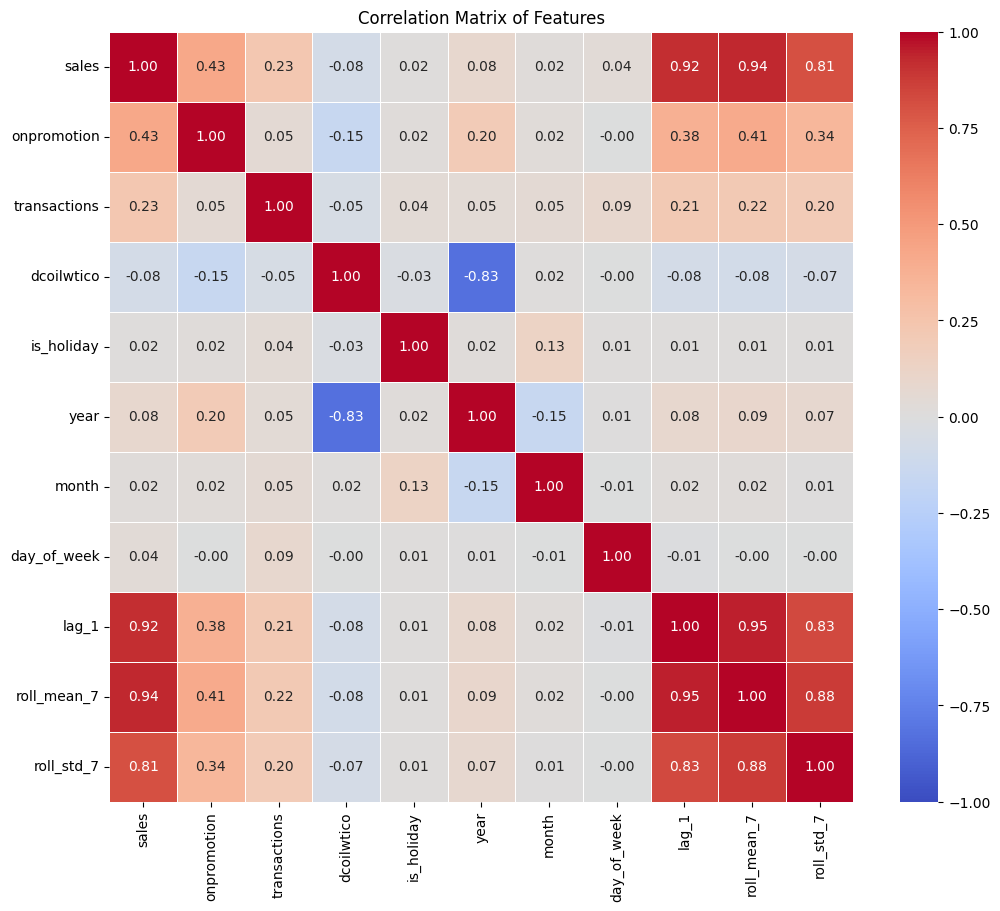

In [8]:
# Correlation Heatmap of Numerical Features

# Select only numeric features

corr_cols = [
    'sales', 'onpromotion', 'transactions', 'dcoilwtico', 'is_holiday',
    'year', 'month', 'day_of_week',
    'lag_1', 'roll_mean_7', 'roll_std_7'
]
corr_matrix = data[corr_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    vmin=-1, vmax=1,
    linewidths=0.5
)
plt.title('Correlation Matrix of Features')
plt.show()

In [9]:
# Drop non-informative & redundant features
#    • id, date: identifiers, not inputs
#    • is_weekend: redundant with day_of_week
to_drop = ['id', 'date', 'is_weekend']
data = data.drop(columns=to_drop)
data.select_dtypes(include='object').columns

Index(['family', 'city', 'state', 'store_type', 'holiday_type', 'locale'], dtype='object')

In [10]:
# Encode categorical columns
label_enc = LabelEncoder()
for col in data.select_dtypes(include='object').columns:
    data[col] = label_enc.fit_transform(data[col].astype(str))

data.head()

,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,dcoilwtico,holiday_type,locale,is_holiday,transactions,year,month,day_of_week,lag_1,roll_mean_7,roll_std_7
0,1,0,2.0,0,18,12,3,13,93.21,5,2,0,1869.0,2013,1,1,0.0,2.142857,1.772811
1,1,1,0.0,0,18,12,3,13,93.21,5,2,0,1869.0,2013,1,1,0.0,0.000000,0.000000
2,1,2,3.0,0,18,12,3,13,93.21,5,2,0,1869.0,2013,1,1,1.0,1.285714,1.380131
3,1,3,1029.0,0,18,12,3,13,93.21,5,2,0,1869.0,2013,1,1,1158.0,812.571429,442.221233
4,1,4,0.0,0,18,12,3,13,93.21,5,2,0,1869.0,2013,1,1,0.0,0.000000,0.000000


In [11]:
# Take a random sample of the data
sample_frac = 0.10   # 10% sample → ~300 K rows
data_sample = data.sample(frac=sample_frac, random_state=42).reset_index(drop=True)
print("Sampled data shape:", data_sample.shape)

Sampled data shape: (304187, 19)


In [12]:
X = data_sample.drop('sales', axis=1)
y = data_sample['sales']

In [13]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [14]:
scaler_features = StandardScaler()
X_train = scaler_features.fit_transform(X_train)
X_test = scaler_features.transform(X_test)
X_val = scaler_features.transform(X_val)

In [15]:
tscv = TimeSeriesSplit(n_splits=3)

In [16]:
# XGBoost Tuning
xgb = XGBRegressor(eval_metric='mae', random_state=42, tree_method="gpu_hist")

xgb_param_dist = {
    'n_estimators':       [20, 50, 100, 150, 200, 300, 500, 750, 1000],
    'max_depth':          [3, 5],
    'learning_rate':      [0.05, 0.1],
    'subsample':          [0.5, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree':   [0.5, 0.7, 0.8, 0.9, 1.0],
    'reg_lambda' : [0.1, 0.5, 1, 2, 5, 10],
    'max_depth' : [3, 4, 5, 6, 7, 8],
    'reg_alpha' : [0, 0.1, 0.5, 1, 2, 5, 10],
    

}

rand_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_param_dist,
    n_iter=20,                           # only 20 random combinations
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42,
    verbose=1,
    error_score='raise'
)

rand_xgb.fit(X_train, y_train)

# Best parameters
print("\nBest XGBoost Parameters:")
print(rand_xgb.best_params_)

# Best model
best_xgb = rand_xgb.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\gregl\Desktop\ML_Projects\Store Sales Forecasting\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:49:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)



Best XGBoost Parameters:
{'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 5, 'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 1.0}


In [17]:
# Random Forest Tuning
rf = RandomForestRegressor(random_state=42)

rf_param_dist = {
    'n_estimators':       [100],
    'max_depth':          [3, 5],
    'min_samples_split':  [20, 50],
    'min_samples_leaf':   [10, 20]
}

rand_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_param_dist,
    n_iter=3,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42,
    verbose=1,
    error_score='raise'
)

rand_rf.fit(X_train, y_train)


# Best parameters
print("\nBest Random Forest Parameters:")
print(rand_rf.best_params_)

# Best model
best_rf = rand_rf.best_estimator_

Fitting 3 folds for each of 3 candidates, totalling 9 fits

Best Random Forest Parameters:
{'n_estimators': 100, 'min_samples_split': 50, 'min_samples_leaf': 10, 'max_depth': 5}


In [18]:
# Define your splits and models
splits = {
    "Train":     (X_train, y_train),
    "Validation":(X_val,   y_val),
    "Test":      (X_test,  y_test),
}
models = {
    "XGBoost":     best_xgb,
    "RandomForest":best_rf,
}

# Collect all metrics in a flat list of dicts
records = []
for split_name, (X, y_true) in splits.items():
    for model_name, model in models.items():
        y_pred = model.predict(X)
        records.append({
            "Model":  model_name,
            "Split":  split_name,
            "MAE":    mean_absolute_error(y_true, y_pred),
            "MSE":    mean_squared_error(y_true, y_pred),
            "R2":     r2_score(y_true, y_pred),
        })

df = pd.DataFrame(records)

# Model Performance Summary

print("\nModel Performance Summary:")
table = (
    df
      .melt(
         id_vars=["Model","Split"],
         value_vars=["MAE","MSE","R2"],
         var_name="Metric",
         value_name="Score"
      )
      .pivot(index="Metric", columns=["Model","Split"], values="Score")
      .round(2)
)
print(table)

c:\Users\gregl\Desktop\ML_Projects\Store Sales Forecasting\.venv\Lib\site-packages\xgboost\core.py:2676: UserWarning: [15:50:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
c:\Users\gregl\Desktop\ML_Projects\Store Sales Forecasting\.venv\Lib\site-packages\xgboost\core.py:729: UserWarning: [15:50:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This


Model Performance Summary:
Model   XGBoost RandomForest    XGBoost RandomForest   XGBoost RandomForest
Split     Train        Train Validation   Validation      Test         Test
Metric                                                                     
MAE       27.63        73.04      49.23        76.06     48.94        76.42
MSE     5218.77     72173.44   40977.81     81679.92  43805.19     86115.56
R2         1.00         0.94       0.97         0.93      0.96         0.93


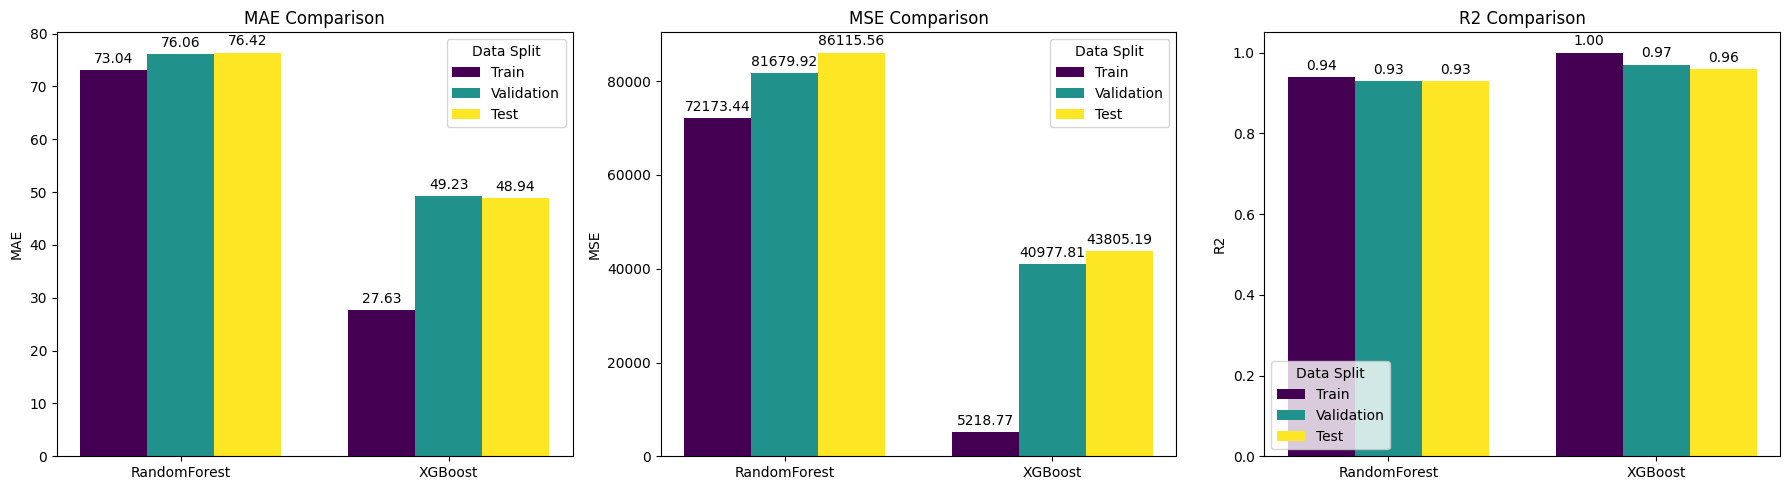

In [19]:
# Bar plot to compare metrics
metrics = ["MAE", "MSE", "R2"]
splits_order = ["Train", "Validation", "Test"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)
cmap = plt.get_cmap("viridis")
n = len(splits_order)
colors = [cmap(i/(n-1)) for i in range(n)]

for ax, metric in zip(axes, metrics):
    # Data for this metric: models × splits
    dfm = table.loc[metric].unstack(level=1).reindex(columns=splits_order)
    x = np.arange(len(dfm.index))
    width = 0.25

    for i, split in enumerate(splits_order):
        bars = ax.bar(x + i*width, dfm[split], width,
                      label=split, color=colors[i])
        # annotate each bar
        ax.bar_label(bars, padding=3, fmt="%.2f")

    ax.set_xticks(x + width, dfm.index)
    ax.set_title(f"{metric} Comparison")
    ax.set_ylabel(metric)
    ax.legend(title="Data Split")

fig.tight_layout()
plt.show()

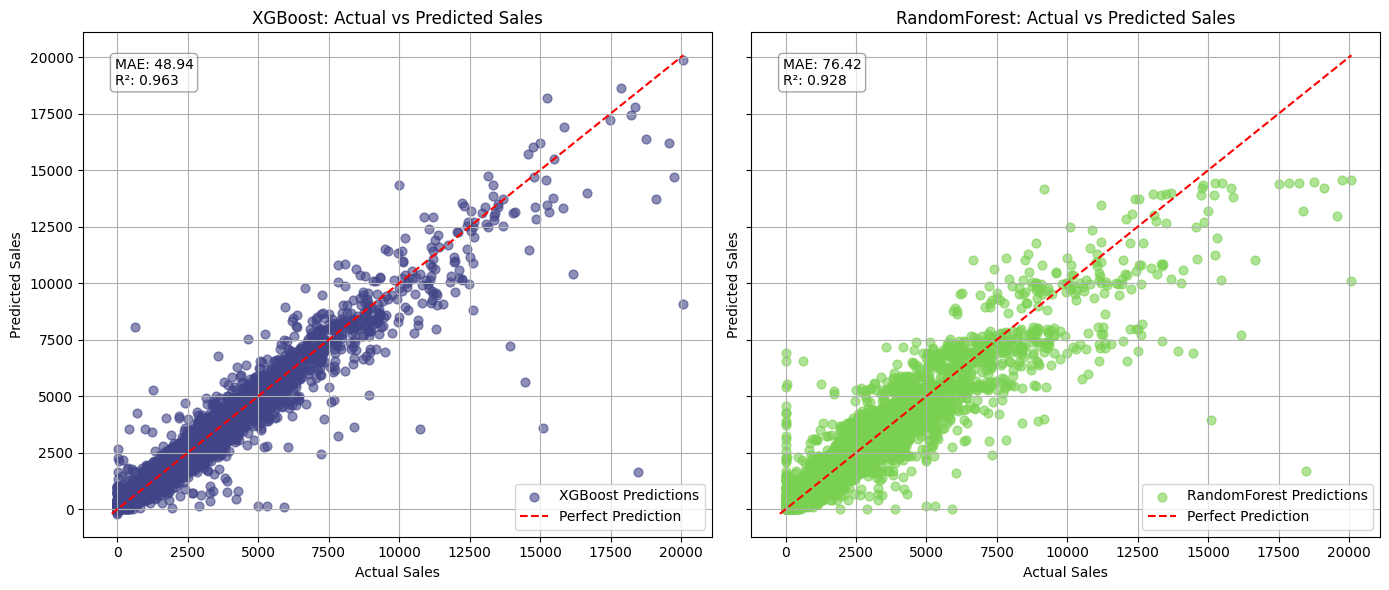

In [20]:
# Actual vs Predicted Sales
X_test_data, y_test_data = X_test, y_test  # adjust if your variable names differ
models = {
    "XGBoost":      best_xgb,
    "RandomForest": best_rf,
}

# Get predictions
preds = {name: model.predict(X_test_data) for name, model in models.items()}

# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)
cmap = plt.get_cmap("viridis")
colors = [cmap(0.2), cmap(0.8)]  # pick two distinct viridis colors

# Determine common plot limits
all_actual = y_test_data
all_predicted = np.concatenate(list(preds.values()))
mn = min(all_actual.min(), all_predicted.min())
mx = max(all_actual.max(), all_predicted.max())

for ax, (name, y_pred), color in zip(axes, preds.items(), colors):
    # scatter
    ax.scatter(y_test_data, y_pred, alpha=0.6, s=40, color=color, label=f"{name} Predictions")
    # perfect-prediction line
    ax.plot([mn, mx], [mn, mx], linestyle="--", color="red", label="Perfect Prediction")

    # metrics
    mae = mean_absolute_error(y_test_data, y_pred)
    r2  = r2_score(y_test_data, y_pred)
    text = f"MAE: {mae:.2f}\nR²: {r2:.3f}"
    ax.text(
        0.05, 0.95, text,
        transform=ax.transAxes,
        fontsize=10,
        va="top",
        bbox=dict(facecolor="white", edgecolor="gray", alpha=0.7, boxstyle="round")
    )

    # labels & title
    ax.set_title(f"{name}: Actual vs Predicted Sales")
    ax.set_xlabel("Actual Sales")
    ax.set_ylabel("Predicted Sales")
    ax.grid(True)
    ax.legend()

# tighten & show
fig.tight_layout()
plt.show()

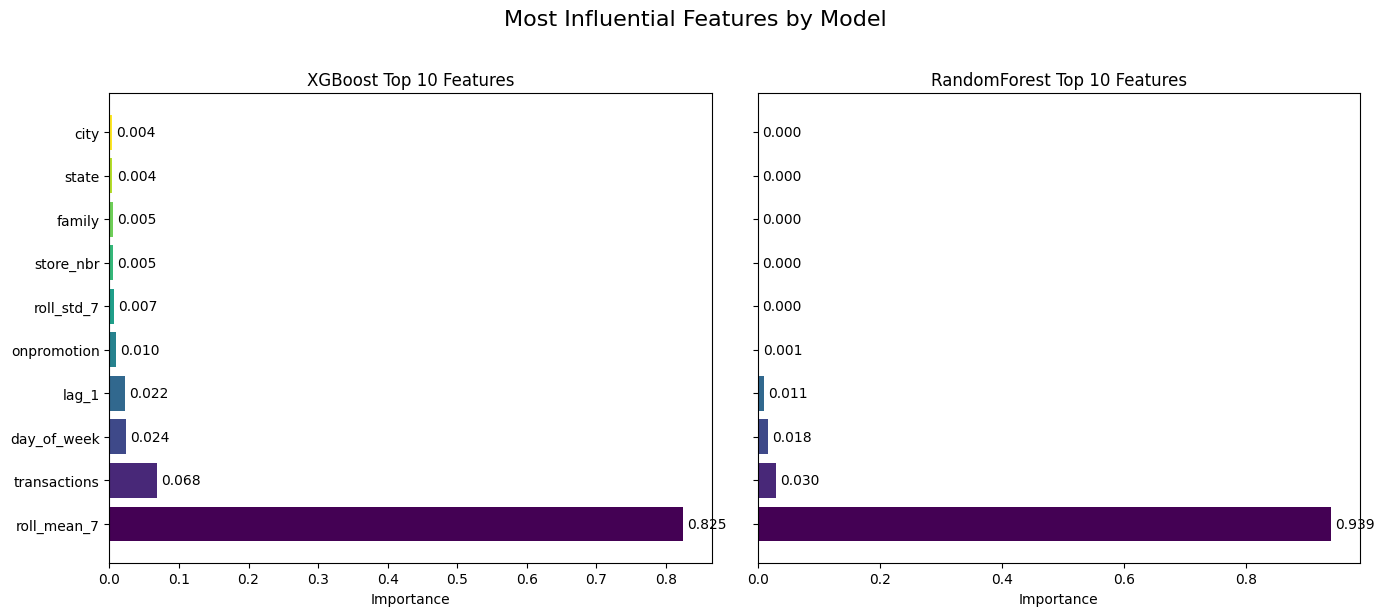

In [21]:
# Identify the most influential features affecting the target variable
# Get feature names (all columns except the target 'sales')
feature_names = [c for c in data_sample.columns if c != "sales"]

# Trained models
models = {
    "XGBoost":      best_xgb,
    "RandomForest": best_rf,
}

# Number of top features to show
top_n = 10

# Extract & sort importances for each model
imps = {}
for name, model in models.items():
    vals   = model.feature_importances_
    series = pd.Series(vals, index=feature_names)
    imps[name] = series.sort_values(ascending=False).head(top_n)

# Plot side-by-side horizontal bars with viridis colormap
fig, axes = plt.subplots(1, len(models), figsize=(14, 6), sharey=True)
cmap   = plt.get_cmap("viridis")
colors = [cmap(i/(top_n-1)) for i in range(top_n)]

for ax, (name, imp_series) in zip(axes, imps.items()):
    # positions & bars
    y_pos = np.arange(len(imp_series))
    bars  = ax.barh(y_pos, imp_series.values, color=colors)

    # label each bar with its importance value
    ax.bar_label(bars, fmt="%.3f", padding=3)

    # set y-ticks to feature names and invert so the highest importance is at the top
    ax.set_yticks(y_pos)
    ax.set_yticklabels(imp_series.index)
    ax.invert_yaxis()

    # titles and grid
    ax.set_title(f"{name} Top {top_n} Features")
    ax.set_xlabel("Importance")

# overall title and layout
fig.suptitle("Most Influential Features by Model", fontsize=16, y=1.02)
fig.tight_layout()
plt.show()


# Submission

In [23]:
test = pd.read_csv('test.csv')

In [24]:
test["date"]=pd.to_datetime(test["date"])
# First merge with other dataframes similar to training process
test=test.merge(stores,on="store_nbr",how="left")
test=test.merge(oil,on="date",how="left")

In [25]:
# Merge datasets
submission = test.merge(stores, on = 'store_nbr', how='left')
submission = submission.merge(oil, on = 'date', how='left')

# Merge with holidays (only non-transferred holidays)
holidays = holidays[holidays['transferred'] == False]
submission = submission.merge(holidays[['date', 'holiday_type', 'locale']], on='date', how='left')
submission['is_holiday'] = submission['holiday_type'].notnull().astype(int)

submission = submission.merge(transactions, on = ['date', 'store_nbr'], how='left')

submission.head()

,id,date,store_nbr,family,onpromotion,city_x,state_x,store_type_x,cluster_x,dcoilwtico_x,city_y,state_y,store_type_y,cluster_y,dcoilwtico_y,holiday_type,locale,is_holiday,transactions
0,3000888,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,46.8,Quito,Pichincha,D,13,46.8,NaN,NaN,0,NaN
1,3000889,2017-08-16,1,BABY CARE,0,Quito,Pichincha,D,13,46.8,Quito,Pichincha,D,13,46.8,NaN,NaN,0,NaN
2,3000890,2017-08-16,1,BEAUTY,2,Quito,Pichincha,D,13,46.8,Quito,Pichincha,D,13,46.8,NaN,NaN,0,NaN
3,3000891,2017-08-16,1,BEVERAGES,20,Quito,Pichincha,D,13,46.8,Quito,Pichincha,D,13,46.8,NaN,NaN,0,NaN
4,3000892,2017-08-16,1,BOOKS,0,Quito,Pichincha,D,13,46.8,Quito,Pichincha,D,13,46.8,NaN,NaN,0,NaN
